In [1]:
!pip install phik

     |████████████████████████████████| 686 kB 18 kB/s eta 0:00:012


#  Описание проекта:

**Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.**

# Цель проекта:

**Обучить несколько моделей на этих данных  для прогноза оттока клиентов**

# План работы:

- **Шаг 1. Загрузка данных**

**Начнём с загрузки данных и их первичного анализа для общего понимания структуры и содержимого.**

- **Шаг 2. Предобработка данных**

**Изучим каждую таблицу отдельно, проведём анализ данных и выполним необходимые шаги для их подготовки. .**

- **Шаг 3. Объединение данных**

**Объединим данные из разных источников в единый датафрейм, выбрав только нужные признаки.**

- **Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма**

**Проанализируем объединённый датафрейм, визуализируем распределение признаков и при необходимости создадим дополнительные. Также проведём корреляционный анализ для оценки взаимосвязей.**

- **Шаг 5. Подготовка данных**

**Подготовим данные для обучения: выполним масштабирование и кодирование, а также разделим выборки на обучающую и тестовую.**

- **Шаг 6. Обучение моделей машинного обучения**

**Обучим минимум две модели машинного обучения. Для одной из моделей произведём настройку гиперпараметров.**

- **Шаг 7. Выбор лучшей модели**

**Оценим результаты моделей и выберем ту, которая показала наилучшие метрики. Проверим её качество на тестовой выборке.**

- **Шаг 8. Общий вывод и рекомендации заказчику**

**Сформулируем выводы по всем этапам работы, представим результаты модели и предложим рекомендации для бизнеса.**

In [60]:
# Импортируем библиотеки
import os
import time
import re
import phik
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import(
    roc_auc_score,
    roc_curve, 
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
) 

STATE=130125
SIZE=0.25

## Загрузка данных

In [3]:
# Функция загрузки данных из файлов в датафреймы
def load_data(file_name):
    data = pd.DataFrame()
    
    path_1 = 'datasets/' + file_name + '.csv'
    path_2 = '/datasets/' + file_name + '.csv'
    
    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
    
    return data



In [4]:
# Пример использования
contract_new = load_data('contract_new')

contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
personal_new = load_data('personal_new')


personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
internet_new = load_data('internet_new')

internet_new.head()


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
phone_new = load_data('phone_new')

phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Предобработка данных

In [8]:
def explore_data(data, name="DataFrame", head_rows=5):
    print(f"{name}: Общая информация")
    print(data.info())
    print("\nОписательная статистика")
    print(data.describe(include="all"))
    print(f"\nПервые {head_rows} строк")
    display(data.head(head_rows))
    print("\n" + "=" * 80 + "\n")


In [9]:
explore_data(contract_new, name="Contract Data")

Contract Data: Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Описательная статистика
        customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77      67               3                2   
top     3521-MNKLV  2014-02-01      No  Month-to-month              Yes   
freq    

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [10]:
print(" Анализ пропусков ")
print(contract_new.isnull().sum())



 Анализ пропусков 
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [11]:
print(" Наличие явных дубликатов ")
duplicate_rows = contract_new.duplicated().sum()
print(f"Явные дубликаты: {duplicate_rows}")
if duplicate_rows > 0:
    print("Примеры дубликатов:")
    print(contract_new[contract_new.duplicated()].head())


 Наличие явных дубликатов 
Явные дубликаты: 0


In [12]:
print(" Наличие неявных дубликатов по customerID ")
if 'customerID' in contract_new.columns:
    unique_ids = contract_new['customerID'].nunique()
    print(f"Уникальных customerID: {unique_ids}")
    print(f"Неявные дубликаты customerID: {contract_new.shape[0] - unique_ids}")



 Наличие неявных дубликатов по customerID 
Уникальных customerID: 7043
Неявные дубликаты customerID: 0


In [13]:
print(" Уникальные значения по каждому столбцу ")
for col in contract_new.columns:
    unique_vals = contract_new[col].unique()
    print(f'Признак "{col}" имеет {len(unique_vals)} уникальных значений.')
    print(f"Уникальные значения: {unique_vals}\n")


 Уникальные значения по каждому столбцу 
Признак "customerID" имеет 7043 уникальных значений.
Уникальные значения: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Признак "BeginDate" имеет 77 уникальных значений.
Уникальные значения: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '

In [14]:
invalid_rows = contract_new[contract_new['TotalCharges'].str.strip() == '']
display(invalid_rows[['BeginDate', 'EndDate', 'TotalCharges']])


,BeginDate,EndDate,TotalCharges
488,2020-02-01,No,
753,2020-02-01,No,
936,2020-02-01,No,
1082,2020-02-01,No,
1340,2020-02-01,No,
3331,2020-02-01,No,
3826,2020-02-01,No,
4380,2020-02-01,No,
5218,2020-02-01,No,
6670,2020-02-01,No,


**Датафрейм contract_new содержит 8 признаков и 7043 записи.
Пропусков в данных нет.**

**Описание признаков:**

**Признак customerID содержит уникальные идентификаторы клиентов.**

**Признаки BeginDate и EndDate содержат даты начала и окончания действия договора. Если в EndDate указано "No", это означает, что договор был активен на 01.02.2020. Оба признака будут удалены, так как они связаны с временными данными, что будет некорректно при прогнозировании на новых выборках. Перед удалением из этих признаков будут созданы два новых признака:**

**contract_status: принимает значение 0 если договор завершён и 1 если активен.**

**contract_duration: содержит продолжительность действия договора в днях. Для расчёта продолжительности значение "No" в EndDate будет заменено на "2020-02-01" (актуальная дата по условию проекта).**

**Признаки Type, PaperlessBilling и PaymentMethod являются категориальными. Они будут преобразованы в числовые значения с помощью метода OrdinalEncoder. (используются только нелинейные модели)**

**Признаки MonthlyCharges и TotalCharges содержат числовую информацию. Признак TotalCharges имеет тип object и будет преобразован в формат float64. Пробелы в этом признаке будут заменены на значение 0, так как их отсутствие интерпретируется как отсутствие оплаты.**

**Все названия признаков будут преобразованы в формат "змеиного регистра", чтобы обеспечить удобный вид оформления.**

In [15]:
contract_new[contract_new['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [16]:
display(contract_new[contract_new['TotalCharges'].str.strip() == ''])


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


**Замечено, что все эти клиенты пользовались услугами только 1 день.**

In [17]:
# Создание признака "contract_status"
contract_new['contract_status'] = 1

contract_new.loc[contract_new['EndDate'] != 'No', 'contract_status'] = 0


In [18]:
# Преобразование типа данных для "BeginDate" в datetime
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'], format='%Y-%m-%d')

# Замена значений "No" в "EndDate" на актуальную дату и преобразование в datetime
contract_new['EndDate'] = pd.to_datetime(
    contract_new['EndDate'].replace('No', '2020-02-01'), 
    format='%Y-%m-%d'
)

# Вычисление продолжительности контракта в днях
contract_new['contract_duration'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.days

# Удаление столбцов "BeginDate" и "EndDate"
contract_new.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)


In [19]:
# Замена пробелов в "TotalCharges" на NaN для последующей обработки
contract_new['TotalCharges'] = contract_new['TotalCharges'].replace(' ', pd.NA)

# Заполнение пропусков значением 0
contract_new['TotalCharges'] = contract_new['TotalCharges'].fillna(0)

# Преобразование типа в float64
contract_new['TotalCharges'] = pd.to_numeric(contract_new['TotalCharges'])


In [20]:
# Приведение названий признаков к "змеиному стилю"
contract_new.columns = (
    contract_new.columns
    .str.replace(r'([A-Z]+)', r'_\1', regex=True) 
    .str.replace(r'_+', '_', regex=True)    
    .str.replace(r'^_|_$', '', regex=True)    
    .str.lower()                                  
)
print('Обновлённые столбцы в contract_new:')
print(contract_new.columns)

Обновлённые столбцы в contract_new:
Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'contract_status',
       'contract_duration'],
      dtype='object')


In [21]:
# Проверка датафрейма после после предобработки данных
print(contract_new.info())
contract_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   contract_status    7043 non-null   int64  
 7   contract_duration  7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB
None


,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_status,contract_duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153


In [22]:
explore_data(personal_new, name="Personal Data")

Personal Data: Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Описательная статистика
        customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     3521-MNKLV   Male            NaN      No         No
freq             1   3555            NaN    3641       4933
mean           NaN    NaN       0.162147     NaN        NaN
std            NaN    NaN       0.368612     NaN        NaN
min            NaN    NaN       0.000000     NaN        NaN

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [23]:
print(" Уникальные значения по каждому столбцу ")
for col in personal_new.columns:
    unique_vals = personal_new[col].unique()
    print(f'Признак "{col}" имеет {len(unique_vals)} уникальных значений.')
    print(f"Уникальные значения: {unique_vals}\n")

 Уникальные значения по каждому столбцу 
Признак "customerID" имеет 7043 уникальных значений.
Уникальные значения: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Признак "gender" имеет 2 уникальных значений.
Уникальные значения: ['Female' 'Male']

Признак "SeniorCitizen" имеет 2 уникальных значений.
Уникальные значения: [0 1]

Признак "Partner" имеет 2 уникальных значений.
Уникальные значения: ['Yes' 'No']

Признак "Dependents" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']



**Датафрейм personal_new содержит 5 признаков и 7043 записи.
Пропусков в данных нет.**

**Описание признаков:**

**Признак customerID представляет собой уникальные идентификаторы клиентов.**

**Признаки gender, SeniorCitizen, Partner и Dependents являются бинарными категориальными. Их преобразование в числовой формат будет выполнено с помощью OrdinalEncoder.**

**Признак SeniorCitizen имеет числовые значения (0 и 1), в отличие от других категориальных признаков. Для упрощения обработки его значения будут преобразованы в No и Yes, а тип данных будет изменён на object.**

**Также нужно обеспечить единообразие названий признаков, они будут приведены к «змеиному стилю».**

In [24]:
# Трансформация значений признака "SeniorCitizen"
personal_new['SeniorCitizen'] = personal_new['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [25]:
personal_new.columns = (
    personal_new.columns
    .str.replace(r'([A-Z]+)', r'_\1', regex=True)
    .str.replace(r'_+', '_', regex=True)
    .str.replace(r'^_|_$', '', regex=True)
    .str.lower()
)
print('Обновлённые столбцы в personal_new:')
print(personal_new.columns)

Обновлённые столбцы в personal_new:
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [26]:
# Проверка датафрейма после после предобработки данных
print(personal_new.info())
personal_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


In [27]:
explore_data(internet_new, name="Internet Data")

Internet Data: Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Описательная статистика
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     5882-CMAZQ     Fiber optic             No           No   
freq             1            3096           3498         3088   


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [28]:
print(" Уникальные значения по каждому столбцу ")
for col in internet_new.columns:
    unique_vals = internet_new[col].unique()
    print(f'Признак "{col}" имеет {len(unique_vals)} уникальных значений.')
    print(f"Уникальные значения: {unique_vals}\n")

 Уникальные значения по каждому столбцу 
Признак "customerID" имеет 5517 уникальных значений.
Уникальные значения: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Признак "InternetService" имеет 2 уникальных значений.
Уникальные значения: ['DSL' 'Fiber optic']

Признак "OnlineSecurity" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']

Признак "OnlineBackup" имеет 2 уникальных значений.
Уникальные значения: ['Yes' 'No']

Признак "DeviceProtection" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']

Признак "TechSupport" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']

Признак "StreamingTV" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']

Признак "StreamingMovies" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']



**Датафрейм internet_new содержит 8 признаков и 5517 записей.
Пропусков в данных не обнаружено.**

**Описание признаков:**

**Признак customerID представляет уникальные идентификаторы клиентов.**

**Признаки InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies являются бинарными категориальными. Эти признаки будут преобразованы в числовой формат с помощью OrdinalEncoder.**

**Для обеспечения единого стиля оформления все названия признаков будут приведены к «змеиному стилю».**

In [29]:
# Приведение признаков к "змеиному стилю"
internet_new.columns = (
    internet_new.columns
    .str.replace(r'([A-Z]+)', r'_\1', regex=True)
    .str.replace(r'_+', '_', regex=True)
    .str.replace(r'^_|_$', '', regex=True)
    .str.lower()
)

print('Обновлённые столбцы в internet_new:')
print(internet_new.columns)

Обновлённые столбцы в internet_new:
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [30]:
explore_data(phone_new, name="Phone Data")

Phone Data: Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Описательная статистика
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     3521-MNKLV            No
freq             1          3390

Первые 5 строк


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [31]:
print(" Уникальные значения по каждому столбцу ")
for col in phone_new.columns:
    unique_vals = phone_new[col].unique()
    print(f'Признак "{col}" имеет {len(unique_vals)} уникальных значений.')
    print(f"Уникальные значения: {unique_vals}\n")

 Уникальные значения по каждому столбцу 
Признак "customerID" имеет 6361 уникальных значений.
Уникальные значения: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

Признак "MultipleLines" имеет 2 уникальных значений.
Уникальные значения: ['No' 'Yes']



**Датафрейм phone_new содержит 2 признака и 6361 запись.
Пропусков в данных нет.**

**Описание признаков:**

**Признак customerID представляет собой уникальные идентификаторы клиентов.**

**Признак MultipleLines является бинарным категориальным. Для преобразования этого признака в числовой формат будет использоваться метод OrdinalEncoder.**

**Для обеспечения единого стиля оформления все названия признаков будут приведены к «змеиному стилю».**

In [32]:
# Приведение признаков к "змеиному стилю"
phone_new.columns = (
    phone_new.columns
    .str.replace(r'([A-Z]+)', r'_\1', regex=True)
    .str.replace(r'_+', '_', regex=True)
    .str.replace(r'^_|_$', '', regex=True)
    .str.lower()
)

print('Обновлённые столбцы в phone_new:')
print(phone_new.columns)

Обновлённые столбцы в phone_new:
Index(['customer_id', 'multiple_lines'], dtype='object')


## Объединение данных

**Объединим все данные в один датафрейм по признаку customer_id**

In [33]:
# Проверка размерностей исходных датафреймов
print('Размерность датафрейма "contract_new":', contract_new.shape)
print('Размерность датафрейма "personal_new":', personal_new.shape)
print('Размерность датафрейма "internet_new":', internet_new.shape)
print('Размерность датафрейма "phone_new":', phone_new.shape)

Размерность датафрейма "contract_new": (7043, 8)
Размерность датафрейма "personal_new": (7043, 5)
Размерность датафрейма "internet_new": (5517, 8)
Размерность датафрейма "phone_new": (6361, 2)


In [34]:
# Объединение всех таблиц в единый датафрейм
data_full = (
    contract_new
    .merge(personal_new, on='customer_id', how='inner')
    .merge(internet_new, on='customer_id', how='left')
    .merge(phone_new, on='customer_id', how='left')
)

# Замена NaN на "no" в столбцах услуг
columns_with_services = ['internet_service', 'online_security', 'online_backup',
                         'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
for col in columns_with_services:
    if col in data_full.columns:
        data_full[col].fillna('Unknown', inplace=True)

# Проверка результата
print('Размер объединённого датафрейма:', data_full.shape)
display(data_full.head())


Размер объединённого датафрейма: (7043, 20)


,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_status,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Unknown
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Unknown
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


**Мы объединили четыре таблицы contract_new, personal_new, internet_new и phone_new в единый датафрейм data_full. Объединение выполнено по ключу customer_id, с использованием различных типов соединений.**

**Объединение contract_new и personal_new:**

**Использован тип соединения inner, так как обе таблицы содержат ключевую информацию о клиентах и договорах, а количество записей в них одинаково.
Такое тип слияния гарантирует, что в итоговом датафрейме будут клиенты, присутствующие в обеих таблицах, без лишних записей.**

**Объединение с internet_new и phone_new:**

**Использован тип соединения left, так как эти таблицы содержат информацию о дополнительных услугах, которые могут быть не подключены у клиентов.
Это позволяет сохранить всех клиентов из объединённого датафрейма, даже если у них не подключены соответсвующие услуги.**

**Обработка отсутствующих данных:**

**Пропуски (NaN), возникающие из-за отсутствия данных об услугах, были заменены значением 'Unknown'. Это позволяет чётко различать отсутствие услуги и отсутствие данных о покупке услуги.**

**Итог:
В результате объединения мы получили единый датафрейм data_combined, содержащий полную информацию о клиентах, их договорах и подключённых услугах. Это обеспечивает целостность данных и готовность к дальнейшему анализу и обучению модели.**

## EDA и предобработка данных объединённого датафрейма

In [35]:
print(data_full.info())
data_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   contract_status    7043 non-null   int64  
 7   contract_duration  7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_status,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Unknown
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Unknown
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


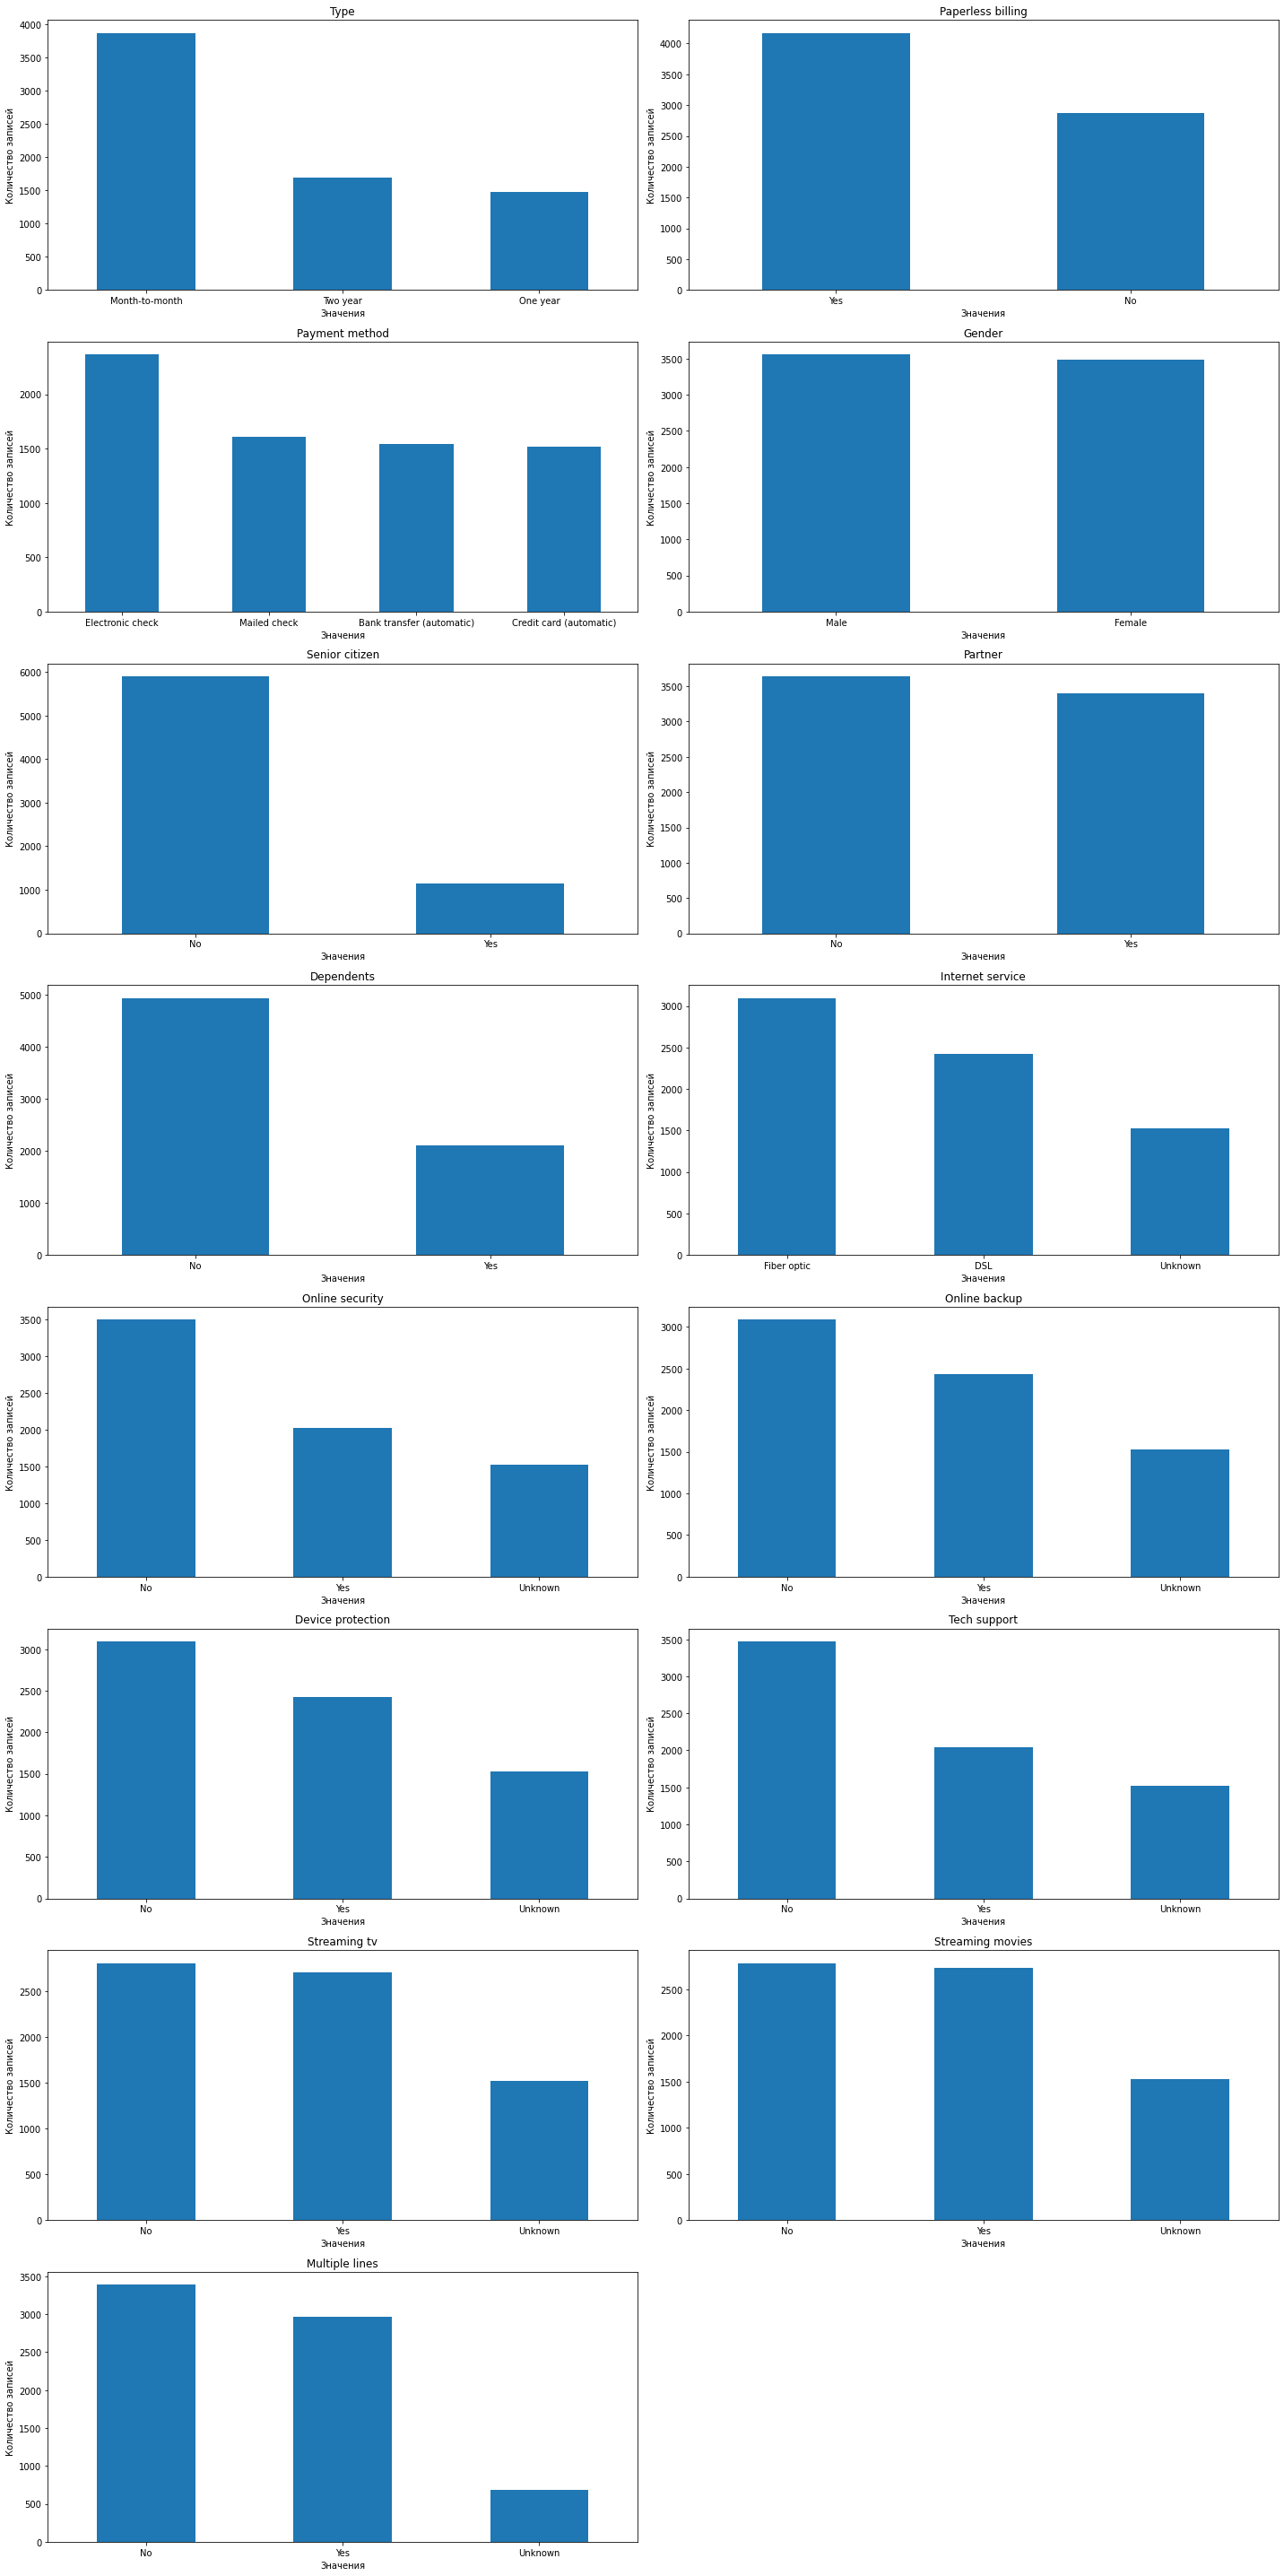

In [36]:
# Определяем категориальные столбцы
categorial_columns = [col for col in data_full.select_dtypes(include=['object']).columns if col != 'customer_id']

# Задаём количество столбцов и строк для графиков
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

# Настройка фигуры
plt.figure(figsize=(20, rows * 5))

# Построение гистограмм для каждого категориального столбца
for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    data_full[column].value_counts().plot(
        kind='bar', 
        ax=ax, 
        title=column.replace('_', ' ').capitalize(), 
        rot=0
    )
    ax.set_ylabel('Количество записей')
    ax.set_xlabel('Значения')

# Отображение графиков
plt.tight_layout()
plt.show()

**Вывод:**

**Самым популярным вариантом оплаты среди клиентов является помесячный контракт. Это неудивительно, так как не все готовы сразу оплачивать большую сумму или связывать себя долгосрочными обязательствами с провайдером, даже несмотря на то, что другие варианты могут быть более выгодными в пересчёте на месяц.**


**Большинство клиентов выбирают получение электронных счетов и предпочитают оплачивать их через электронный чек.**

**Наиболее часто используемый способ подключения — оптоволоконный интернет. Это связано с его более высокой скоростью и стабильностью в сравнении с DSL, что делает его предпочтительным выбором для большинства пользователей.**


**Дополнительные услуги:
Услуги, такие как Online Security, Online Backup, Device Protection, Tech Support, StreamingTV, Streaming Movies и Multiple Lines, используются значительно реже, что указывает на их низкую востребованность среди клиентов.**


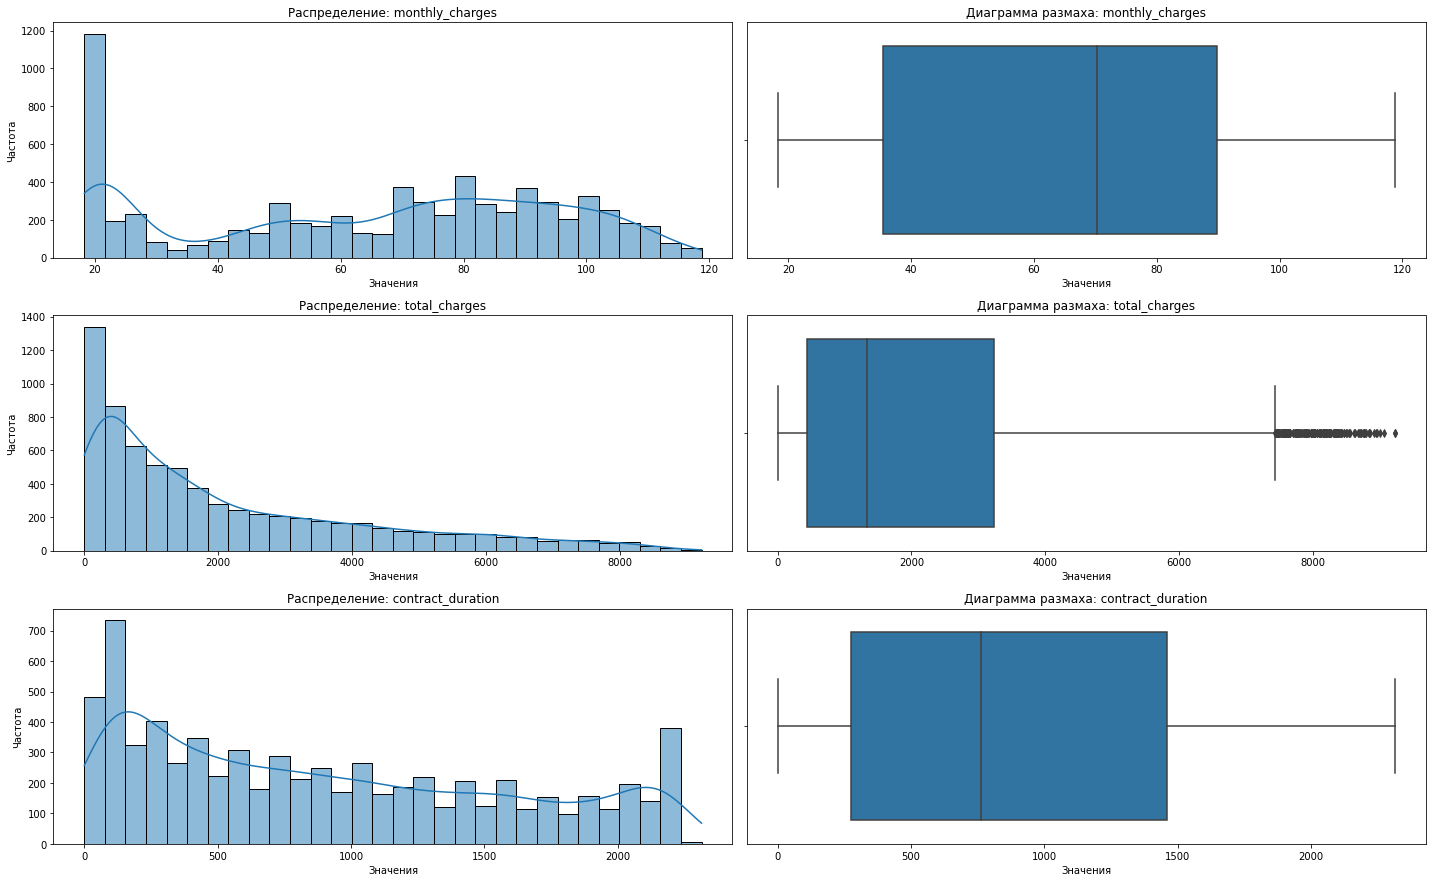

Для признака monthly_charges:
Среднее значение: 64.76
Минимум: 18.25, Максимум: 118.75
Медиана: 70.35
25-й и 75-й процентили: 35.50, 89.85

Для признака total_charges:
Среднее значение: 2115.31
Минимум: 0.00, Максимум: 9221.38
Медиана: 1343.35
25-й и 75-й процентили: 436.75, 3236.69

Для признака contract_duration:
Среднее значение: 898.56
Минимум: 0.00, Максимум: 2314.00
Медиана: 761.00
25-й и 75-й процентили: 276.00, 1461.00



In [37]:
# Определяем количественные данные
numeric_columns = [col for col in data_full.select_dtypes(include=['float64', 'int64']).columns if col != 'contract_status']



# Построение графиков распределения и диаграмм размаха
cols = 2
rows = int(np.ceil(len(numeric_columns) / cols))

plt.figure(figsize=(20, rows * 8))

for idx, column in enumerate(numeric_columns):
    # Гистограмма
    plt.subplot(rows * 2, cols, idx * 2 + 1)
    sns.histplot(data_full[column], kde=True, bins=30)
    plt.title(f'Распределение: {column}')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    
    # Диаграмма размаха
    plt.subplot(rows * 2, cols, idx * 2 + 2)
    sns.boxplot(x=data_full[column])
    plt.title(f'Диаграмма размаха: {column}')
    plt.xlabel('Значения')

plt.tight_layout()
plt.show()

numeric_stats = data_full[numeric_columns].describe()

# Интерпретация (примерно):
for column in numeric_columns:
    print(f"Для признака {column}:")
    print(f"Среднее значение: {numeric_stats.loc['mean', column]:.2f}")
    print(f"Минимум: {numeric_stats.loc['min', column]:.2f}, Максимум: {numeric_stats.loc['max', column]:.2f}")
    print(f"Медиана: {numeric_stats.loc['50%', column]:.2f}")
    print(f"25-й и 75-й процентили: {numeric_stats.loc['25%', column]:.2f}, {numeric_stats.loc['75%', column]:.2f}")
    print()

- **Признак monthly_charges:**

**Гистограмма:
Значения распределены равномерно, с пиком в диапазоне около 20-30.
Большинство клиентов платят меньше 40-70 в месяц, что соответствует медиане 70.35.**

**Диаграмма размаха:
Нет явных выбросов.
Признак показывает равномерное распределение.**

**Вывод:
Большинство клиентов предпочитают недорогие тарифы, что может указывать на чувствительность к цене.**

- **Признак total_charges:**

**Гистограмма:
Распределение с сильным перевесом влево: много клиентов с небольшими общими расходами.
Есть длинный хвост с высокими значениями до 9221.38, но это редкость.**

**Диаграмма размаха:
Присутствуют выбросы среди клиентов с очень высокими расходами.
Медиана 1343.35 значительно меньше 75-го перцентиля 3236.69, что указывает на длинный правый хвост.**

**Вывод:
Большинство клиентов только начинают использовать услуги или пользуются недорогими тарифами.
Высокие значения могут соответствовать клиентам с долгими контрактами.**

- **Признак contract_duration:**

**Гистограмма:
Два явных пика:
Клиенты с минимальной длительностью контракта (новые пользователи).
Клиенты с длительными контрактами (около 2-3 лет).**

**Диаграмма размаха:
Нет явных выбросов.
Средняя продолжительность (898.56 дней) выше медианы (761.00 дней), что говорит о присутствие долгосрочных клиентов.**

**Вывод:
Клиенты делятся на две основные группы: новые пользователи и долгосрочные клиенты.
Долгосрочные клиенты могут быть менее склонны к оттоку.**

**Для total_charges следует проанализировать выбросы, так как это может быть связано с аномальными данными или c категориями клиентов.**

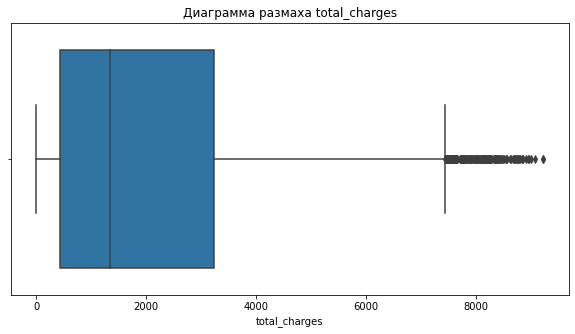

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=data_full['total_charges'])
plt.title('Диаграмма размаха total_charges')
plt.show()

In [39]:
# Вычисление квартилей и IQR
q1 = data_full['total_charges'].quantile(0.25)
q3 = data_full['total_charges'].quantile(0.75)
iqr = q3 - q1

# Граница выбросов
upper_bound = q3 + 1.5 * iqr

# Вывод границ
print(f"Граница выбросов: {upper_bound:.2f}")

# Фильтрация выбросов
outliers = data_full[data_full['total_charges'] > upper_bound]
print(f"Количество выбросов: {len(outliers)}")

# Пример выбросов
display(outliers.head(15))



Граница выбросов: 7436.60
Количество выбросов: 195


,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_status,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
17,9959-WOFKT,Two year,No,Bank transfer (automatic),106.70,8257.51,1,2163,Male,No,No,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes
57,5067-XJQFU,One year,Yes,Electronic check,108.45,7730.32,1,2010,Male,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
59,5954-BDFSG,Two year,Yes,Credit card (automatic),107.50,7740.00,1,2191,Female,No,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
106,6728-DKUCO,One year,Yes,Electronic check,104.15,7498.80,1,2191,Female,No,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,Yes
198,7255-SSFBC,Two year,Yes,Bank transfer (automatic),112.25,8324.46,1,2191,Male,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
369,3520-FJGCV,Two year,Yes,Credit card (automatic),112.60,8755.78,1,2191,Male,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
437,4376-KFVRS,Two year,Yes,Credit card (automatic),114.05,8211.60,1,2191,Male,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
449,1090-ESELR,Two year,No,Bank transfer (automatic),105.50,7596.00,1,2191,Male,No,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No
464,1480-BKXGA,Two year,Yes,Bank transfer (automatic),116.05,8355.60,1,2191,Male,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
483,5168-MQQCA,One year,Yes,Bank transfer (automatic),108.50,8358.84,1,2191,Female,No,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes


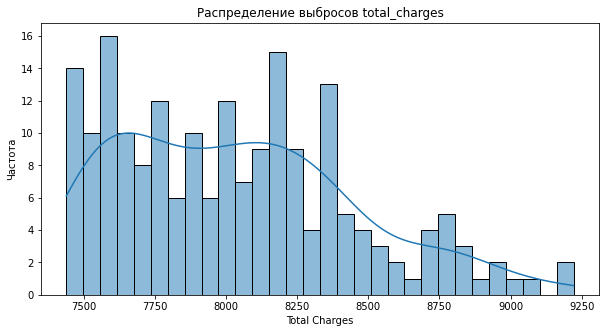

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(outliers['total_charges'], kde=True, bins=30)
plt.title('Распределение выбросов total_charges')
plt.xlabel('Total Charges')
plt.ylabel('Частота')
plt.show()

**Выбросы логически обоснованы:**

- **Высокие значения total_charges связаны с долгосрочными контрактами и большим количеством подключенных услуг.**

- **Эти клиенты представляют собой премиум-сегмент, и выбросы являются корректными данными.**

In [41]:
# Использование pivot_table для анализа
for column in categorial_columns:
    pivot = data_full.pivot_table(index=column, columns='contract_status', aggfunc='size', fill_value=0)
    pivot = pivot.div(pivot.sum(axis=1), axis=0)  # Нормализация
    print(f"\nРаспределение значений признака '{column}' относительно целевого признака (pivot_table):")
    display(pivot)



Распределение значений признака 'type' относительно целевого признака (pivot_table):


contract_status,0,1
type,,
Month-to-month,0.105032,0.894968
One year,0.212492,0.787508
Two year,0.224779,0.775221



Распределение значений признака 'paperless_billing' относительно целевого признака (pivot_table):


contract_status,0,1
paperless_billing,,
No,0.132312,0.867688
Yes,0.172860,0.827140



Распределение значений признака 'payment_method' относительно целевого признака (pivot_table):


contract_status,0,1
payment_method,,
Bank transfer (automatic),0.205311,0.794689
Credit card (automatic),0.208279,0.791721
Electronic check,0.147992,0.852008
Mailed check,0.072581,0.927419



Распределение значений признака 'gender' относительно целевого признака (pivot_table):


contract_status,0,1
gender,,
Female,0.151376,0.848624
Male,0.161181,0.838819



Распределение значений признака 'senior_citizen' относительно целевого признака (pivot_table):


contract_status,0,1
senior_citizen,,
No,0.147263,0.852737
Yes,0.203152,0.796848



Распределение значений признака 'partner' относительно целевого признака (pivot_table):


contract_status,0,1
partner,,
No,0.104916,0.895084
Yes,0.211346,0.788654



Распределение значений признака 'dependents' относительно целевого признака (pivot_table):


contract_status,0,1
dependents,,
No,0.148591,0.851409
Yes,0.174408,0.825592



Распределение значений признака 'internet_service' относительно целевого признака (pivot_table):


contract_status,0,1
internet_service,,
DSL,0.142916,0.857084
Fiber optic,0.192183,0.807817
Unknown,0.104849,0.895151



Распределение значений признака 'online_security' относительно целевого признака (pivot_table):


contract_status,0,1
online_security,,
No,0.150372,0.849628
Unknown,0.104849,0.895151
Yes,0.205547,0.794453



Распределение значений признака 'online_backup' относительно целевого признака (pivot_table):


contract_status,0,1
online_backup,,
No,0.123381,0.876619
Unknown,0.104849,0.895151
Yes,0.230548,0.769452



Распределение значений признака 'device_protection' относительно целевого признака (pivot_table):


contract_status,0,1
device_protection,,
No,0.126333,0.873667
Unknown,0.104849,0.895151
Yes,0.227085,0.772915



Распределение значений признака 'tech_support' относительно целевого признака (pivot_table):


contract_status,0,1
tech_support,,
No,0.156349,0.843651
Unknown,0.104849,0.895151
Yes,0.194716,0.805284



Распределение значений признака 'streaming_tv' относительно целевого признака (pivot_table):


contract_status,0,1
streaming_tv,,
No,0.127046,0.872954
Unknown,0.104849,0.895151
Yes,0.215737,0.784263



Распределение значений признака 'streaming_movies' относительно целевого признака (pivot_table):


contract_status,0,1
streaming_movies,,
No,0.120287,0.879713
Unknown,0.104849,0.895151
Yes,0.221816,0.778184



Распределение значений признака 'multiple_lines' относительно целевого признака (pivot_table):


contract_status,0,1
multiple_lines,,
No,0.094395,0.905605
Unknown,0.151026,0.848974
Yes,0.228206,0.771794


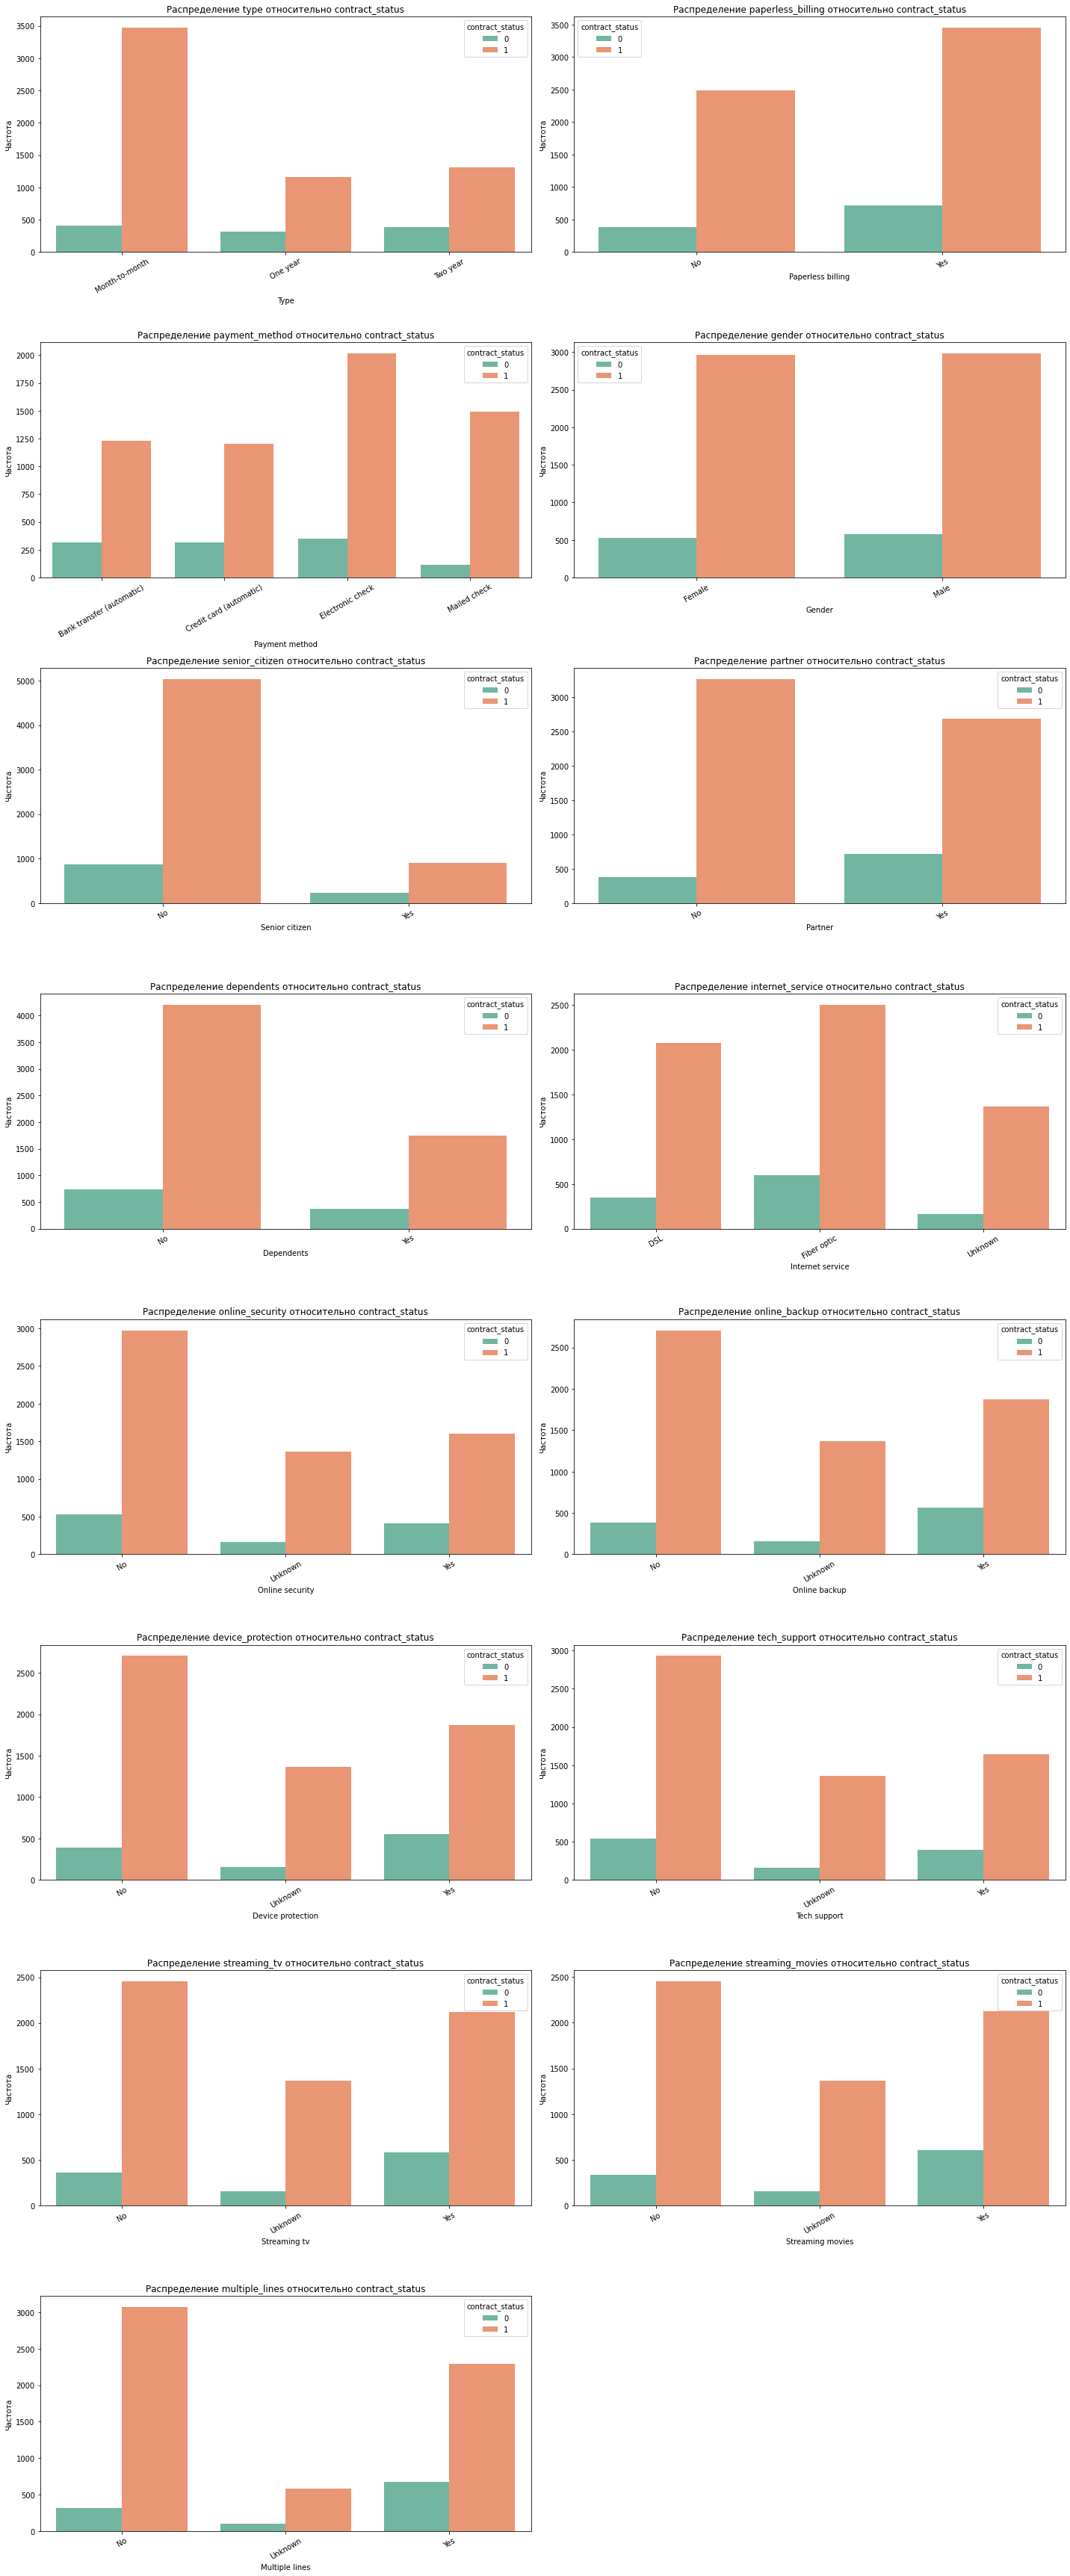

In [42]:
# Построение графиков для каждого категориального признака
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, rows * 6))

for idx, column in enumerate(categorial_columns, 1):
    plt.subplot(rows, cols, idx)
    
    # Построение распределения с разделением по contract_status
    data_plot = (
        data_full.groupby([column, 'contract_status'])
        .size()
        .reset_index(name='count')
    )
    
    sns.barplot(
        data=data_plot,
        x=column,
        y='count',
        hue='contract_status',
        palette='Set2'
    )
    
    plt.title(f'Распределение {column} относительно contract_status')
    plt.xlabel(column.replace('_', ' ').capitalize())
    plt.ylabel('Частота')
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [43]:
type_distribution = data_full.groupby(['type', 'contract_status'])['customer_id'].count().unstack()


type_distribution_percentage = type_distribution.div(type_distribution.sum(axis=1), axis=0) * 100

# Вывод числовых данных
print("Абсолютные значения распределения:")
display(type_distribution)

print("Процентное распределение:")
display(type_distribution_percentage)


Абсолютные значения распределения:


contract_status,0,1
type,,
Month-to-month,407,3468
One year,313,1160
Two year,381,1314


Процентное распределение:


contract_status,0,1
type,,
Month-to-month,10.503226,89.496774
One year,21.249151,78.750849
Two year,22.477876,77.522124


**Вывод:**

- **Тип контракта:**

**Помесячные контракты показывают самое большое количество активных клиентов в процентах. Это может быть связано с гибкостью и отсутствием долгосрочных обязательств.
Двухлетние контракты имеют самый высокий процент завершений (22.5%), что может быть связано с тем, что длительные обязательства менее привлекательны для некоторых клиентов.**

- **Методы оплаты:**

**Методы автоматической оплаты, такие как банковские переводы или кредитные карты, имеют низкий процент завершений контрактов. Это говорит об удобстве данных методов и меньшем желании клиентов отказаться от услуги.
Электронные чеки имеют самый высокий процент завершений, что может быть связано с менее удобным процессом оплаты.**

- **Дополнительные услуги:**

**Клиенты, не подключающие дополнительные услуги например онлайн-защита, резервное копирование или поддержка, чаще остаются активными. Люди предпочитают минимальные расходы.
Напротив, подключение дополнительных услуг может увеличивать вероятность завершения контракта, что связано с их стоимостью или неудовлетворенностью качеством.**

- **Тип подключения к интернету:**

**Клиенты с подключением через оптоволокно имеют более высокий процент завершения контрактов, в сравнении с другими.
Пользователи DSL и те, кто вообще не использует интернет, чаще остаются активными. Полагаю это может быть связано с тем, что процесс смены провайдера требует времени и эти клиенты предпочитают избегать дополнительных забот, связанных с этим.**

- **Персональные характеристики:**

**Пожилые клиенты чаще завершают контракты, скорее всего по личным причинам или из-за технических ограничений.
Клиенты с иждивенцами имеют более высокий процент завершений.
Наличие партнера снижает вероятность завершения контракта.**


Распределение для contract_status = 1:



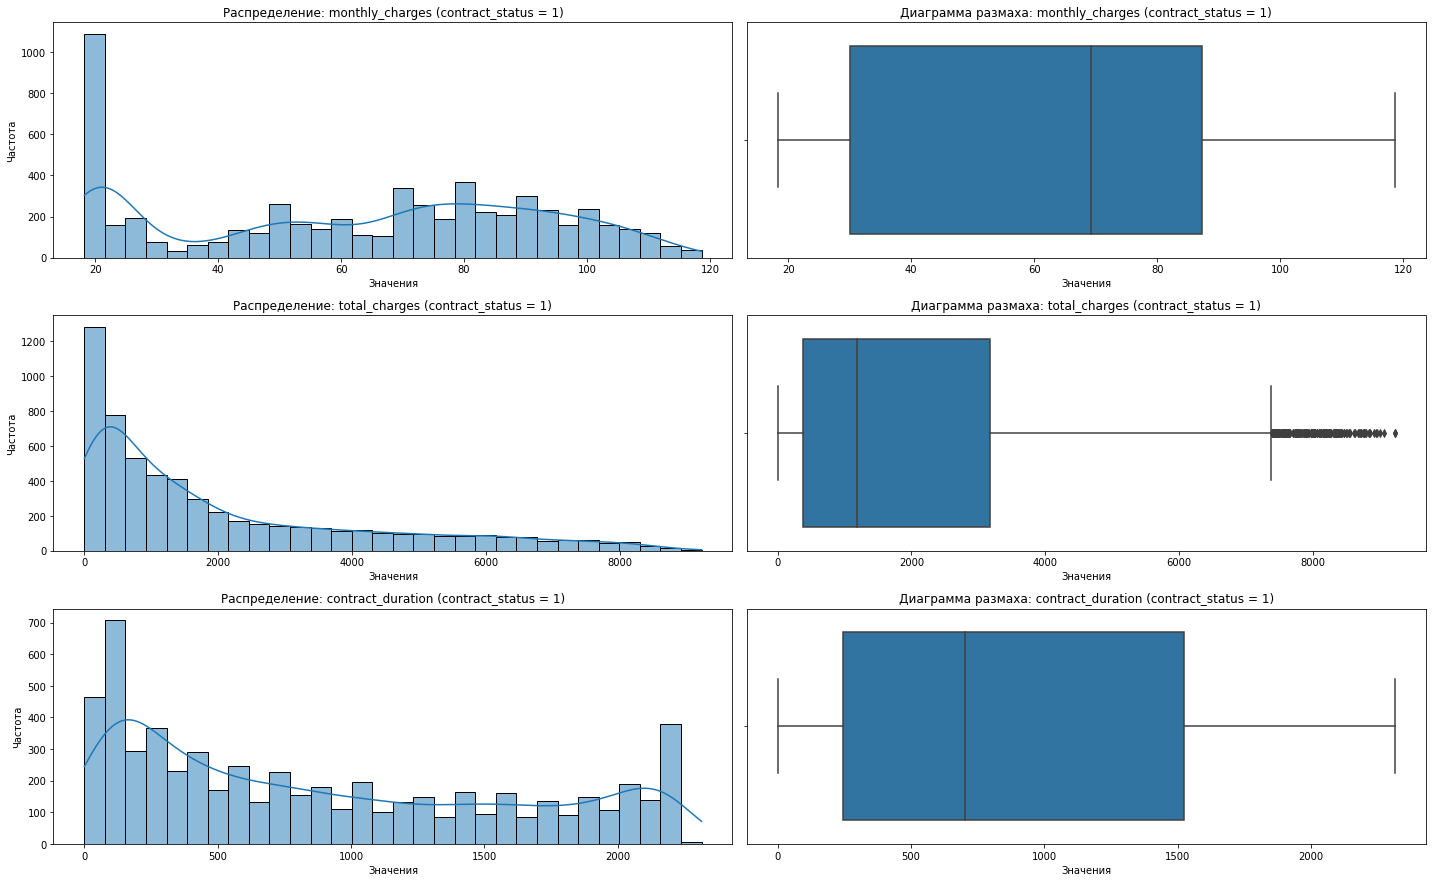

,count,mean,std,min,25%,50%,75%,max
monthly_charges,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.60
total_charges,5942.0,2067.866420,2193.898483,0.00,374.3525,1192.8,3173.8375,9221.38
contract_duration,5942.0,893.681084,716.958551,0.00,245.0000,702.0,1523.0000,2314.00



Распределение для contract_status = 0:



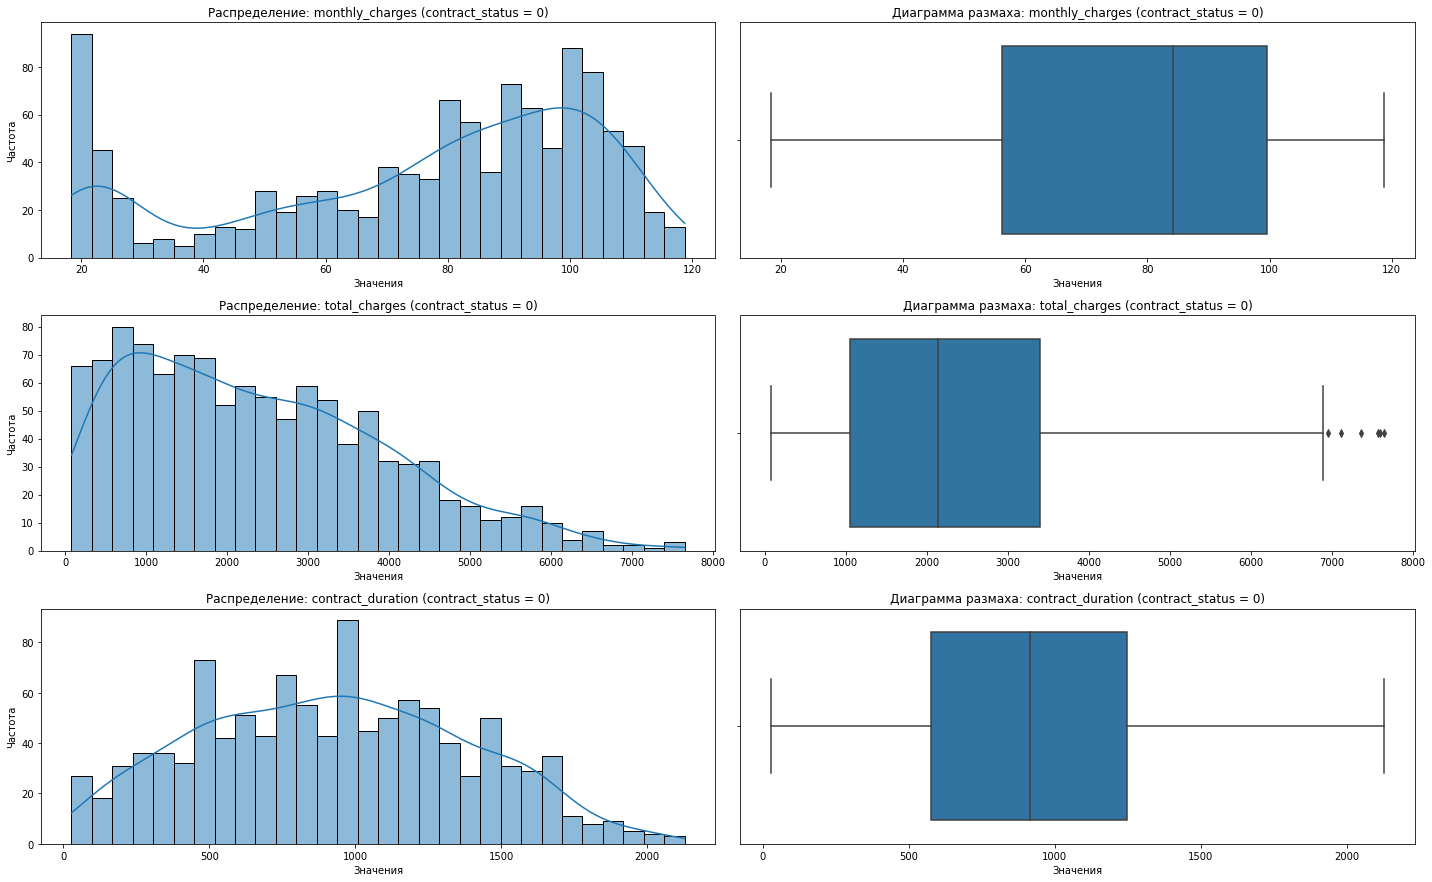

,count,mean,std,min,25%,50%,75%,max
monthly_charges,1101.0,75.546004,29.116213,18.40,56.15,84.20,99.50,118.75
total_charges,1101.0,2371.377275,1581.862275,77.84,1048.05,2139.03,3404.91,7649.76
contract_duration,1101.0,924.863760,458.771309,28.00,577.00,915.00,1249.00,2129.00


In [44]:
# Уникальные значения целевого признака
target_values = data_full['contract_status'].unique()

for target_value in target_values:
    print(f"\nРаспределение для contract_status = {target_value}:\n")

    # Построение графиков
    cols = 2
    rows = int(np.ceil(len(numeric_columns) / cols))
    plt.figure(figsize=(20, rows * 8))

    for idx, column in enumerate(numeric_columns):
        # Гистограмма
        plt.subplot(rows * 2, cols, idx * 2 + 1)
        sns.histplot(data_full[data_full['contract_status'] == target_value][column], kde=True, bins=30)
        plt.title(f'Распределение: {column} (contract_status = {target_value})')
        plt.xlabel('Значения')
        plt.ylabel('Частота')
        
        # Диаграмма размаха
        plt.subplot(rows * 2, cols, idx * 2 + 2)
        sns.boxplot(x=data_full[data_full['contract_status'] == target_value][column])
        plt.title(f'Диаграмма размаха: {column} (contract_status = {target_value})')
        plt.xlabel('Значения')

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    numeric_stats = data_full[data_full['contract_status'] == target_value][numeric_columns].describe().T
    display(numeric_stats)

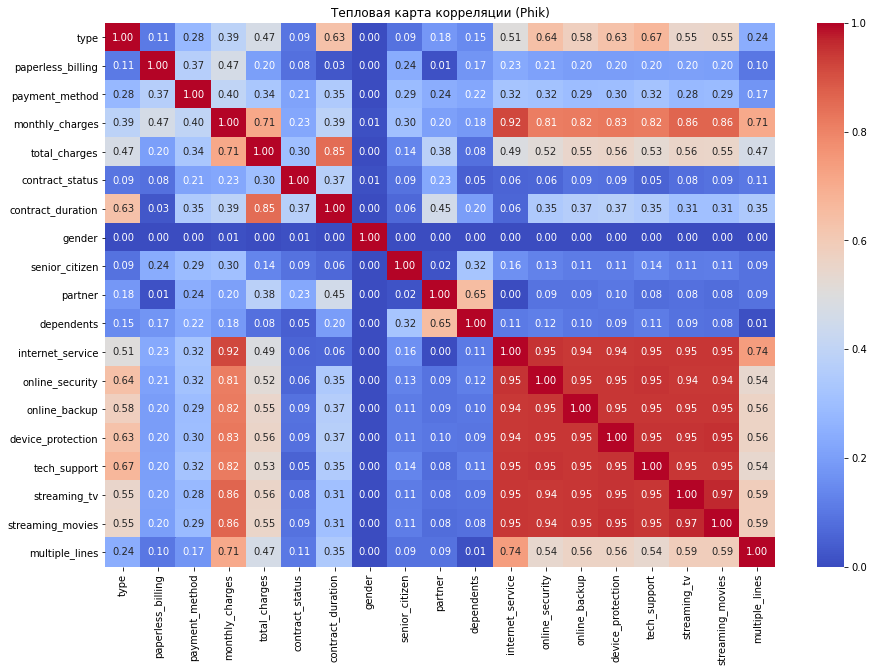

In [45]:
# Расчет матрицы корреляции с помощью Phik
phik_corr_matrix = data_full.drop('customer_id', axis=1).phik_matrix(interval_cols=numeric_columns)

# Построение тепловой карты
plt.figure(figsize=(15, 10))
sns.heatmap(phik_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Тепловая карта корреляции (Phik)")
plt.show()

**Выводы:**

**Чем дольше клиент остается пользователем, тем ниже вероятность, что он прекратит сотрудничество.**

**Более высокая ежемесячная стоимость услуг увеличивает вероятность отказа клиента от дальнейшего обслуживания.**

**Чем больше сервисов, тем выше платеж.**

## Подготовка данных

In [46]:
target = data_full['contract_status']

features = data_full.drop(columns=['contract_status', 'customer_id'])

# Разделение на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=SIZE, random_state=STATE
)


**Выделили целевой и входные признаки, а также разделили выборки на обучающую и тестовую.**

In [47]:
numeric_columns = [col for col in features_train.select_dtypes(include=['float64', 'int64']).columns]

features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()

# Масштабирование числовых данных
scaler = StandardScaler()
features_train_scaled[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])
features_test_scaled[numeric_columns] = scaler.transform(features_test[numeric_columns])

# Проверка результата
print(features_train_scaled[numeric_columns].head())
print(features_test_scaled[numeric_columns].head())

      monthly_charges  total_charges  contract_duration
4602        -1.279678      -0.177250           1.676695
3837         1.356523      -0.687040          -1.052315
7035         0.463429      -0.254290          -0.470361
1849        -0.635126      -0.740476          -0.786321
70          -0.519140      -0.975621          -1.277161
      monthly_charges  total_charges  contract_duration
6074        -1.367496      -0.967210          -1.187516
4585         0.673861      -0.874223          -1.187516
991         -1.337671      -0.328940           1.274030
6444         0.488283       0.308511           0.245324
5902        -0.459490      -0.778455          -0.917114


**Выполнили масштабирование для числовых признаков**

In [48]:
categorical_columns = [col for col in features_train.select_dtypes(include='object').columns]

features_train_encoded = features_train.copy()
features_test_encoded = features_test.copy()

# Применение OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_encoded[categorical_columns] = encoder.fit_transform(features_train[categorical_columns])
features_test_encoded[categorical_columns] = encoder.transform(features_test[categorical_columns])

**Применили OrdinalEncoder для того чтобы преобразовать категориальные признаки.**

In [49]:
# Создание объединённых датафреймов
features_train_prepared = features_train_scaled.copy()
features_train_prepared[categorical_columns] = features_train_encoded[categorical_columns]

features_test_prepared = features_test_scaled.copy()
features_test_prepared[categorical_columns] = features_test_encoded[categorical_columns]

**Теперь features_train_prepared и features_test_prepared содержат все необходимые данные.**

## Обучение моделей машинного обучения

# RandomForest

In [50]:
# Определение параметров для подбора
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10], 
    'min_samples_leaf': [1, 10],
    'n_estimators': [100, 150, 200],
}

# Инициализация модели
model = RandomForestClassifier(random_state=STATE)

# Настройка GridSearchCV
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, 
    scoring='roc_auc', 
    verbose=1, 
    n_jobs=-1  
)

# Обучение GridSearchCV на тренировочной выборке
search.fit(features_train_prepared, target_train)

# Вывод лучших параметров и результата на кросс-валидации
print("Лучшие параметры:", search.best_params_)
print("Лучший AUC (на кросс-валидации):", search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Лучший AUC (на кросс-валидации): 0.8316973819787103


# LightGBM

In [51]:
# Определение гиперпараметров для подбора
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}

# Инициализация модели
model = LGBMClassifier(random_state=STATE)

# Настройка GridSearchCV
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Обучение GridSearchCV
search.fit(features_train_prepared, target_train)

# Вывод лучших параметров
print("Лучшие параметры:", search.best_params_)
print("Лучший AUC (на кросс-валидации):", search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие параметры: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}
Лучший AUC (на кросс-валидации): 0.8878823726242777


# CatBoost

In [52]:
# Параметры для подбора
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'iterations': [200],
    'l2_leaf_reg': [0.1, 1, 3]
}

# Инициализация модели
model = CatBoostClassifier(random_state=STATE, verbose=0)

# Настройка GridSearchCV
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  
    scoring='roc_auc', 
    verbose=0,
    n_jobs=-1  
)

# Обучение GridSearchCV
search.fit(features_train_prepared, target_train)

# Вывод лучших параметров
print("Лучшие параметры:", search.best_params_)
print("Лучший AUC (на кросс-валидации):", search.best_score_)

Лучшие параметры: {'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
Лучший AUC (на кросс-валидации): 0.9000863591183375


**Модель CatBoost продемонстрировала наилучший результат по метрике ROC-AUC, достигнув значения 0.90**

## Выбор лучшей модели

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Учтено.</div>

In [53]:
# Лучшие параметры модели CatBoost
best_params = search.best_params_

# Финальная модель с лучшими параметрами
best_model = CatBoostClassifier(**best_params, random_state=STATE, verbose=0)

# Обучение модели на всей обучающей выборке
best_model.fit(features_train_prepared, target_train)
    

<div class="alert alert-success">
<b>👍 Успех:</b> Лучшая модель выбрана!
</div>

In [54]:
# Предсказание вероятностей для тестовой выборки
predicted_probabilities = best_model.predict_proba(features_test_prepared)[:, 1]

# Рассчёт ROC-AUC на тестовой выборке
roc_auc = roc_auc_score(target_test, predicted_probabilities)
print(f"ROC-AUC на тестовой выборке: {roc_auc:.2f}")


ROC-AUC на тестовой выборке: 0.90


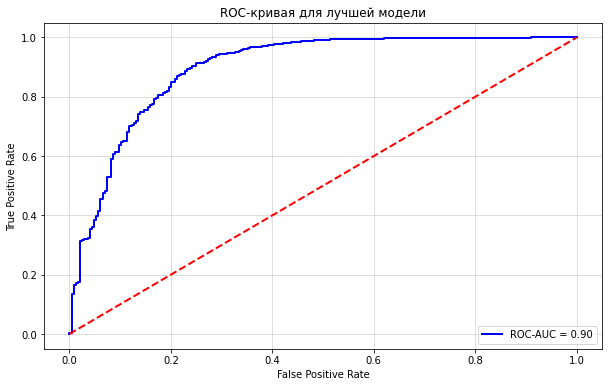

In [56]:
# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(target_test, predicted_probabilities)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для лучшей модели')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()


<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [57]:
# Предсказания классов
predict = best_model.predict(features_test_prepared)

# Подсчёт accuracy
accuracy = accuracy_score(target_test, predict)

print(f"Точность (Accuracy) на тестовой выборке: {accuracy:.2f}")

Точность (Accuracy) на тестовой выборке: 0.92


**Модель корректно определяет класс объекта в 92% случаев, что свидетельствует о её высокой эффективности.**

<div class="alert alert-success">
<b>👍 Успех:</b> Да, отличный результат!
</div>

**Узнаем важность признаков**

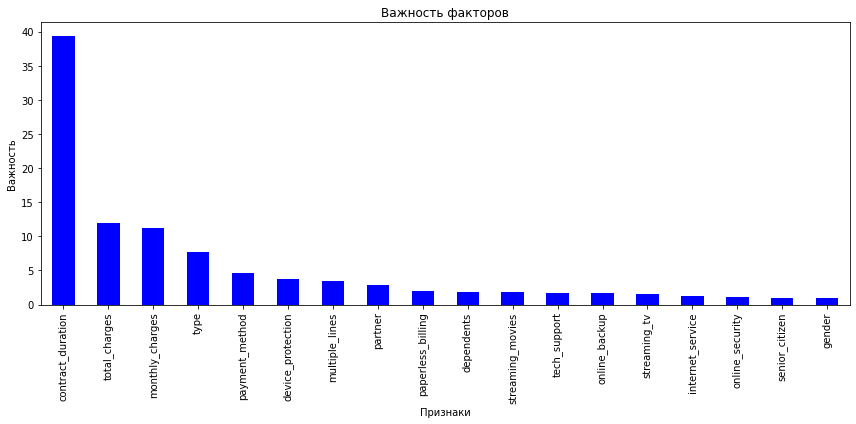

,Importance
contract_duration,39.391948
total_charges,11.973720
monthly_charges,11.207041
type,7.727096
payment_method,4.556351
device_protection,3.804028
multiple_lines,3.512965
partner,2.883396
paperless_billing,2.004124
dependents,1.908837


In [58]:
# Создание DataFrame с важностью признаков
feature_importances = pd.DataFrame({
    'Importance': search.best_estimator_.feature_importances_
}, index=features_test_prepared.columns).sort_values(by='Importance', ascending=False)

# Построение графика
feature_importances.plot(kind='bar', figsize=(12, 6), legend=False, title='Важность факторов', color='b')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Вывод DataFrame для просмотра
feature_importances

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Нужно добавить матрицу ошибок</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Матрица ошибок добавлена </div>

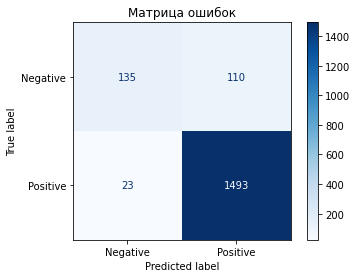

In [62]:
# Предсказания на тестовой выборке
predicted_classes = search.best_estimator_.predict(features_test_prepared)

# Матрица ошибок
cm = confusion_matrix(target_test, predicted_classes)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
cm_display.plot(cmap="Blues")  
plt.title("Матрица ошибок")  
plt.show()

**Анализ матрицы ошибок показывает, что выбранная модель успешно предсказывает большинство случаев класса 1 Positive с минимальным числом ошибок. Из 1516 случаев расторжения договоров модель ошибается всего в 23 случаях, что демонстрирует её высокую точность для этого класса.**

**С предсказанием класса 0 Negative модель справляется несколько хуже: из 245 случаев 110 предсказаны неверно, что составляет около 45% ошибок в данном классе. Это говорит о том, что модель имеет склонность к переоценке вероятности расторжения договора.**

**Вывод: модель хорошо справляется с предсказанием расторжения договора, но может улучшить точность для клиентов, которые остаются с компанией.**

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Общий вывод и рекомендации заказчику

**Итоговый вывод:**

В данной работе была решена задача предсказания оттока клиентов.

Загрузка и предварительный анализ данных:

Данные были загружены и изучены. Проведён анализ распределения признаков и выявлены ключевые особенности.

Предобработка данных:

Проведена очистка и трансформация данных: столбцы переименованы, типы данных приведены к корректным форматам.
Добавлены новые признаки: целевой признак contract_status, показывающий ушел клиент или нет, и contract_duration, отражающий продолжительность контракта.
Устранены пропуски и обработаны категориальные признаки.

Исследовательский анализ данных:

Проведён анализ количественных и категориальных признаков, их распределения и зависимости от целевого признака.
Клиенты, использующие более дорогие тарифы и дополнительные услуги, чаще расторгают договоры.
Со временем вероятность отказа от услуг снижается, так как долгосрочные клиенты менее склонны к уходу.

Подготовка данных для обучения моделей:

Выполнено масштабирование числовых признаков и кодирование категориальных данных.
Данные разделены на обучающую и тестовую выборки.
Проведён анализ мультиколлинеарности, что позволило оставить все признаки для обучения.

Обучение моделей:

Были обучены и настроены три модели: RandomForestClassifier, CatBoostClassifier, и LGBMClassifier.
Наилучший результат показала модель CatBoostClassifier, достигнув значения ROC-AUC = 0.90.

Выводы по значимости признаков:

Наиболее важные признаки для модели:
contract_duration — длительность контракта.
total_charges — общая сумма платежей.
monthly_charges — ежемесячные платежи.

**Рекомендации для бизнеса:**
Разработать программы лояльности для клиентов с помесячной оплатой, чтобы увеличить их приверженность.

Предложить долгосрочные скидки для клиентов с годовым или двухлетним контрактом.

Работа с клиентами с высоким риском отказа:

Клиентам с высокой стоимостью ежемесячных платежей предлагать персонализированные тарифы или скидки.

Долгосрочные стратегии:

Разработать акционные предложения для новых клиентов, ориентированные на долгосрочное использование услуг.

<div class="alert alert-success">
<b>👍 Успех:</b> Молодец, финальный проект завершен! Сама работа получилась хорошей и структурированной, были предобработаны и проанализированы данные, выбран целевой признак, рассчеты подкреплены визуализацией, это очень важная часть работы, которая облегчает анализ и позволяет полнее представлять происходящее в данных. Построено и обучено несколько моделей, все они оценены и выбрана лучшая. Цель работы достигнута, получена модель хорошо предсказывающая уход клиентов. Не забывай о том, что все пункты очень важны и каждому стоит уделять максимум внимания. <p>
С опытом становится значительно легче, но опыт это не только повторение однажды изученного, но и постоянное развитие, тем более, что ты выбрал очень динамично развивающуюся область. <p>
В будущей профессии тебе точно пригодиться умение системно подходить к решению аналитических задач, здесь рекомендую изучить ТРИЗ и системный анализ, из литературы можно почитать Теоретический минимум по Big Data — Су Кеннет и Ын Анналин, Практическая статистика для специалистов Data Science — Брюс П. и Брюс Э., Real-World Machine Learning — Henric Brink, Joseph Мark, W. Richards Fetherolf, Прикладное машинное обучение с помощью Scikit-Learn и TensorFlow — Жерон Орельен.<p>
Есть интересные сообщества (например https://vk.com/mashinnoe_obuchenie_ai_big_data) и конечно же https://habr.com/ru/all/<p>

Дополнительно предлагаю посмотреть:
- Книга от ШАД: https://academy.yandex.ru/handbook/ml

- Открытый курс машинного обучения: https://habr.com/ru/company/ods/blog/322626/

 Удачи тебе и профессионального роста!
</div>